1. LSTM was used to analyze the data of four quarters and check the training results. According to the model, forecast the data for the next seven days

Predicting Outbound Demand - Next 7 Days:
Epoch 0 Loss: 0.14688019454479218
Epoch 10 Loss: 0.02685811184346676
Epoch 20 Loss: 0.07181297987699509
Epoch 30 Loss: 0.12398197501897812
Epoch 40 Loss: 0.12667566537857056
Epoch 50 Loss: 0.1157553493976593
Epoch 60 Loss: 0.13852548599243164
Epoch 70 Loss: 0.11601827293634415
Epoch 80 Loss: 0.08585761487483978
Epoch 90 Loss: 0.07365060597658157
Epoch 100 Loss: 0.1175747960805893
Epoch 110 Loss: 0.12279317528009415
Epoch 120 Loss: 0.11132033169269562
Epoch 130 Loss: 0.1407718062400818
Epoch 140 Loss: 0.06302888691425323
Epoch 150 Loss: 0.09158113598823547
Epoch 160 Loss: 0.08059675246477127
Epoch 170 Loss: 0.05178256332874298
Epoch 180 Loss: 0.04989313334226608
Epoch 190 Loss: 0.043810345232486725


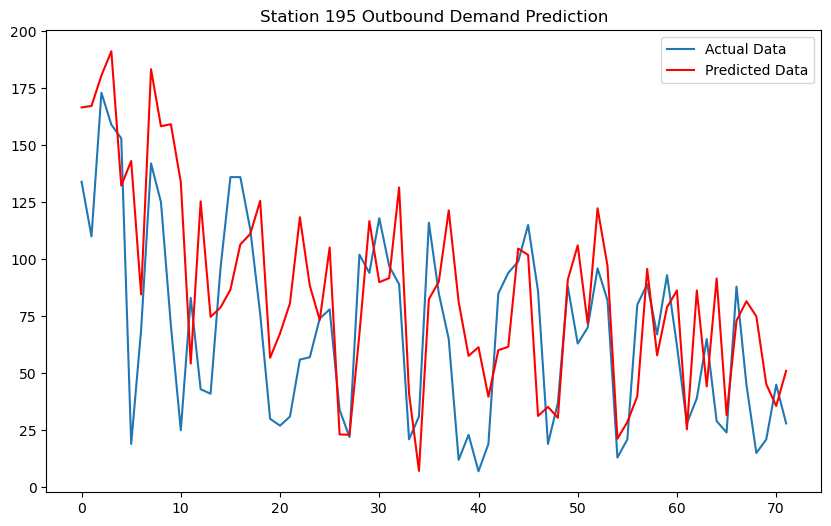

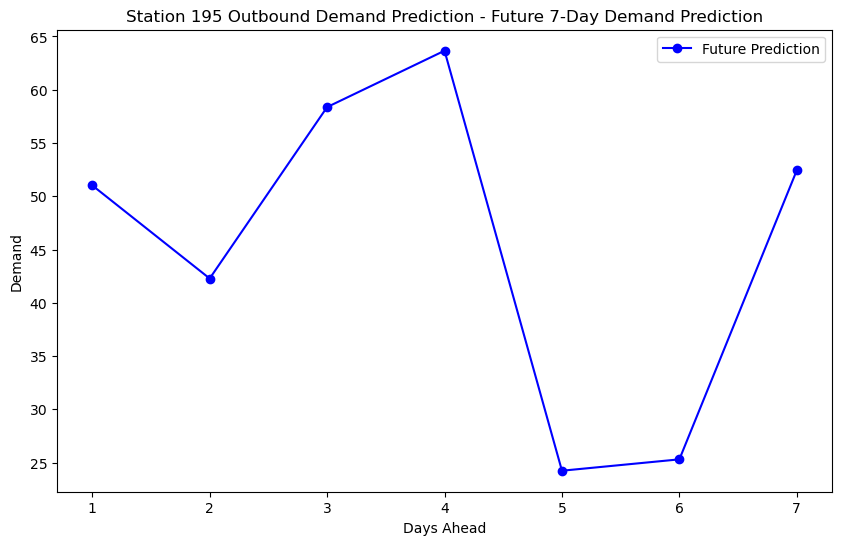

Predicting Inbound Demand - Next 7 Days:
Epoch 0 Loss: 0.40169650316238403
Epoch 10 Loss: 0.10472498089075089
Epoch 20 Loss: 0.02222939021885395
Epoch 30 Loss: 0.0210247952491045
Epoch 40 Loss: 0.01478850282728672
Epoch 50 Loss: 0.019515514373779297
Epoch 60 Loss: 0.013595589436590672
Epoch 70 Loss: 0.012594236060976982
Epoch 80 Loss: 0.005943350028246641
Epoch 90 Loss: 0.004600467626005411
Epoch 100 Loss: 0.0019021263578906655
Epoch 110 Loss: 0.0104321064427495
Epoch 120 Loss: 0.007059273310005665
Epoch 130 Loss: 0.03938615322113037
Epoch 140 Loss: 0.0026202898006886244
Epoch 150 Loss: 0.0054581863805651665
Epoch 160 Loss: 0.0021192452404648066
Epoch 170 Loss: 0.0005030408501625061
Epoch 180 Loss: 0.013569685630500317
Epoch 190 Loss: 0.003346460871398449


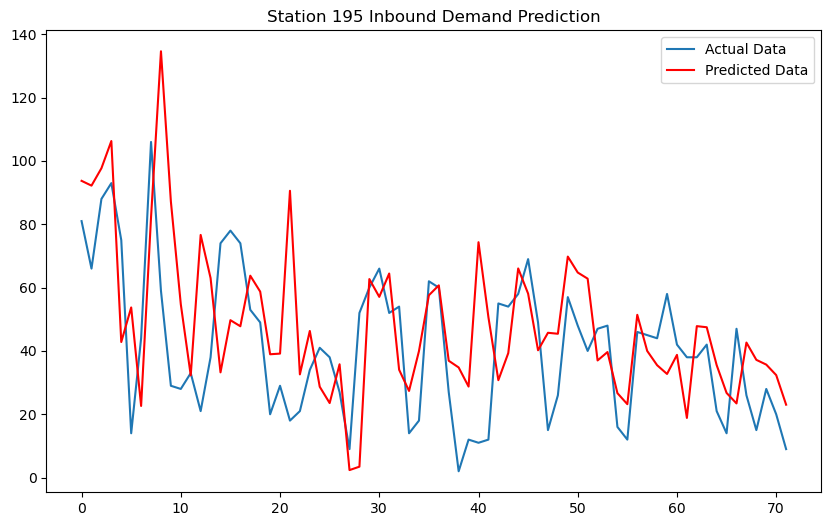

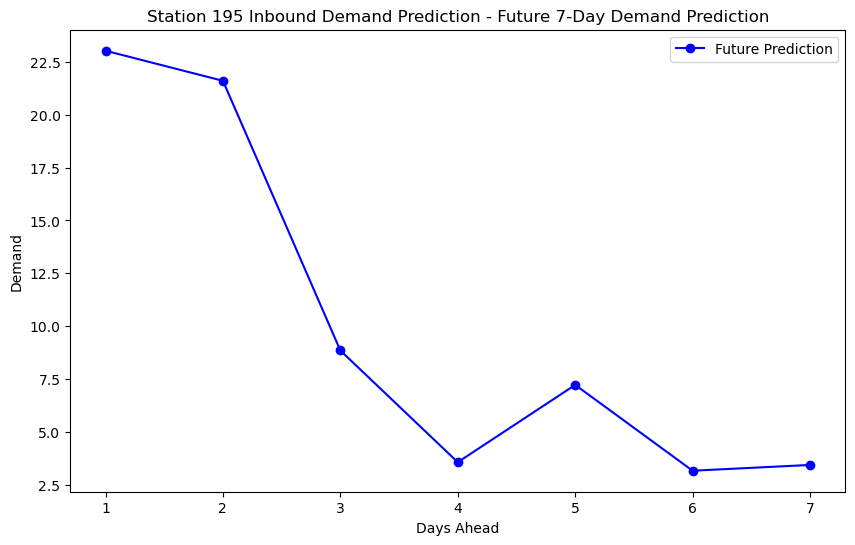

In [23]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Load and prepare data

# Load data for all four quarters
quarters = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 
            'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df_list = [pd.read_csv(file) for file in quarters]
df = pd.concat(df_list, ignore_index=True)

# Convert times to dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date


# Select data for a specific station (e.g., station ID 195)
station_id = 195
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()

# Fill missing dates with 0 and set daily frequency
outbound_series = outbound_data.asfreq('D', fill_value=0)
inbound_series = inbound_data.asfreq('D', fill_value=0)


# 2. Normalize data

scaler_out = MinMaxScaler(feature_range=(-1, 1))
outbound_series_scaled = scaler_out.fit_transform(outbound_series.values.reshape(-1, 1))

scaler_in = MinMaxScaler(feature_range=(-1, 1))
inbound_series_scaled = scaler_in.fit_transform(inbound_series.values.reshape(-1, 1))


# 3. Prepare dataset
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


seq_length = 7  # Use the past 7 days as an input sequence
X_out, y_out = create_sequences(outbound_series_scaled, seq_length)
X_in, y_in = create_sequences(inbound_series_scaled, seq_length)

# Split into training and testing sets (e.g., 80% training, 20% testing)
train_size_out = int(len(X_out) * 0.8)
X_train_out, X_test_out = X_out[:train_size_out], X_out[train_size_out:]
y_train_out, y_test_out = y_out[:train_size_out], y_out[train_size_out:]

train_size_in = int(len(X_in) * 0.8)
X_train_in, X_test_in = X_in[:train_size_in], X_in[train_size_in:]
y_train_in, y_test_in = y_in[:train_size_in], y_in[train_size_in:]


# Convert to PyTorch tensors
X_train_out = torch.tensor(X_train_out, dtype=torch.float32)
y_train_out = torch.tensor(y_train_out, dtype=torch.float32)
X_test_out = torch.tensor(X_test_out, dtype=torch.float32)
y_test_out = torch.tensor(y_test_out, dtype=torch.float32)

X_train_in = torch.tensor(X_train_in, dtype=torch.float32)
y_train_in = torch.tensor(y_train_in, dtype=torch.float32)
X_test_in = torch.tensor(X_test_in, dtype=torch.float32)
y_test_in = torch.tensor(y_test_in, dtype=torch.float32)

# 4. Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 5. Train and prediction function, supporting future seven-day prediction
def train_and_predict_future(model, X_train, y_train, X_test, y_test, scaler, title, future_steps=7):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    
    epochs = 200
    for i in range(epochs):
        for seq, labels in zip(X_train, y_train):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {single_loss.item()}')

    # Predict and restore data
    model.eval()
    with torch.no_grad():
        predictions = []
        for seq in X_test:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())

    # Inverse transform predictions for testing data
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

    # Visualize predictions on testing data
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Data')
    plt.plot(predictions, label='Predicted Data', color='red')
    plt.legend()
    plt.title(title)
    plt.show()

    # Predict the next seven days
    future_predictions = []
    last_seq = X_test[-1]  # Start from the last sequence in testing data
    for _ in range(future_steps):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        with torch.no_grad():
            prediction = model(last_seq).item()
            future_predictions.append(prediction)
        
        # Update sequence: remove the oldest and append the latest prediction
        last_seq = torch.cat((last_seq[1:], torch.tensor([[prediction]])))
    
    # Inverse transform future predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    
    # Visualize the next seven days of predictions
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, future_steps + 1), future_predictions, marker='o', color='blue', label='Future Prediction')
    plt.title(f'{title} - Future 7-Day Demand Prediction')
    plt.xlabel('Days Ahead')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

    return future_predictions

# 6. Create two models for inbound and outbound demand, and make predictions
model_out = LSTMModel()
model_in = LSTMModel()

# Forecast for the next 7 days based on four quarters of data
print('Predicting Outbound Demand - Next 7 Days:')
future_outbound = train_and_predict_future(model_out, X_train_out, y_train_out, X_test_out, y_test_out, scaler_out, f'Station {station_id} Outbound Demand Prediction', future_steps=7)

print('Predicting Inbound Demand - Next 7 Days:')
future_inbound = train_and_predict_future(model_in, X_train_in, y_train_in, X_test_in, y_test_in, scaler_in, f'Station {station_id} Inbound Demand Prediction', future_steps=7)



Analyze patterns over a 24-hour period


Outbound Forecast:
Epoch 0 Loss: 0.00398745434358716
Epoch 10 Loss: 0.0010078634368255734
Epoch 20 Loss: 0.0016308092745020986
Epoch 30 Loss: 0.0016668858006596565
Epoch 40 Loss: 0.0046110739931464195
Epoch 50 Loss: 0.0028524426743388176
Epoch 60 Loss: 0.00257221981883049
Epoch 70 Loss: 0.004265131428837776
Epoch 80 Loss: 0.00151322060264647
Epoch 90 Loss: 0.00170259946025908


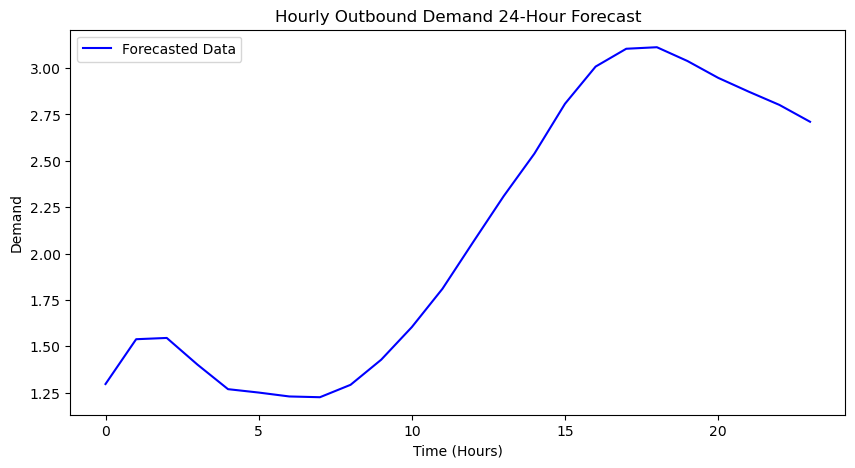

Inbound Forecast:
Epoch 0 Loss: 0.0022253335919231176
Epoch 10 Loss: 0.0011572310468181968
Epoch 20 Loss: 0.00016660983965266496
Epoch 30 Loss: 1.1156833352288231e-05
Epoch 40 Loss: 1.9969096683780663e-05
Epoch 50 Loss: 1.9628561176432413e-07
Epoch 60 Loss: 6.611069693462923e-05
Epoch 70 Loss: 2.674356619536411e-05
Epoch 80 Loss: 0.0003358045651111752
Epoch 90 Loss: 0.00027467854670248926


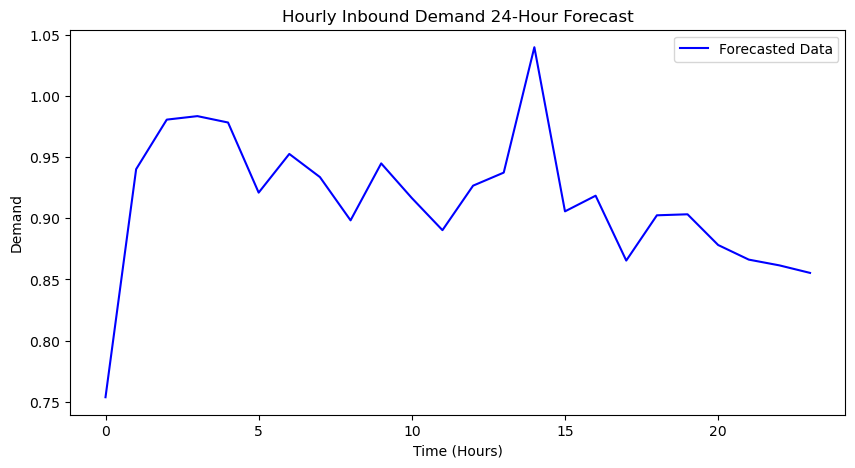

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Load data
files = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']

df_all = pd.DataFrame()

for file in files:
    # Read data
    df = pd.read_csv(file)
    
    # Convert times to hourly timestamps
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['start_hour'] = df['start_time'].dt.floor('H')
    df['end_hour'] = df['end_time'].dt.floor('H')
    
    # Append current quarter data to the total dataset
    df_all = pd.concat([df_all, df], ignore_index=True)

# 3. Select the station ID to analyze
station_id = 195  # Example station ID

# 4. Calculate hourly outbound and inbound counts for the station
outbound_data = df[df['from_station_id'] == station_id].groupby('start_hour').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_hour').size()

# Fill missing hourly data with 0 and set hourly frequency
outbound_series = outbound_data.asfreq('H', fill_value=0)
inbound_series = inbound_data.asfreq('H', fill_value=0)

# 5. Normalize data
scaler_out = MinMaxScaler(feature_range=(-1, 1))
outbound_series_scaled = scaler_out.fit_transform(outbound_series.values.reshape(-1, 1))

scaler_in = MinMaxScaler(feature_range=(-1, 1))
inbound_series_scaled = scaler_in.fit_transform(inbound_series.values.reshape(-1, 1))

# 6. Create sequence function
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 24  # Use the past 24 hours of data to predict the next hour
X_out, y_out = create_sequences(outbound_series_scaled, seq_length)
X_in, y_in = create_sequences(inbound_series_scaled, seq_length)

# Convert to PyTorch tensors
X_out = torch.tensor(X_out, dtype=torch.float32)
y_out = torch.tensor(y_out, dtype=torch.float32)
X_in = torch.tensor(X_in, dtype=torch.float32)
y_in = torch.tensor(y_in, dtype=torch.float32)

# 7. Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# 8. Training and prediction function
def train_and_predict(model, X, y, scaler, title):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100

    # Train the model
    for i in range(epochs):
        for seq, labels in zip(X, y):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {single_loss.item()}')

    # Forecast the next 24 hours
    model.eval()
    with torch.no_grad():
        predictions = []
        seq = X[-1]  # Start with the last sequence of the training data
        for _ in range(24):  # Forecast for the next 24 hours
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            predictions.append(y_pred.item())
            seq = torch.cat((seq[1:], y_pred.view(1, -1)))  # Sliding window

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Visualize the forecast
    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Forecasted Data', color='blue')
    plt.title(f'{title} 24-Hour Forecast')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

# 9. Train and forecast for outbound and inbound
print('Outbound Forecast:')
model_out = LSTMModel()
train_and_predict(model_out, X_out, y_out, scaler_out, 'Hourly Outbound Demand')
torch.save(model_out.state_dict(), f'model_out_station_{station_id}.pth')  # Save the outbound model


print('Inbound Forecast:')
model_in = LSTMModel()
train_and_predict(model_in, X_in, y_in, scaler_in, 'Hourly Inbound Demand')
torch.save(model_in.state_dict(), f'model_in_station_{station_id}.pth')  # Save the inbound model


